In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cấu hình hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

In [12]:
# ==========================================
# 1. TẢI VÀ CHUẨN BỊ DỮ LIỆU
# ==========================================
print("--- 1. Đang xử lý dữ liệu ---")
# Tải dữ liệu Iris
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Chia dữ liệu (70% Train, 30% Test)
# stratify=y đảm bảo tỉ lệ các lớp hoa đều nhau trong cả 2 tập
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Chuẩn hóa dữ liệu (Scaling) - Rất quan trọng với k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Kích thước tập huấn luyện: {X_train_scaled.shape}")
print(f"Kích thước tập kiểm tra: {X_test_scaled.shape}")
print("-" * 60)


--- 1. Đang xử lý dữ liệu ---
Kích thước tập huấn luyện: (105, 4)
Kích thước tập kiểm tra: (45, 4)
------------------------------------------------------------


In [13]:
# ==========================================
# 2. HÀM HỖ TRỢ PHÂN TÍCH VÀ VẼ BIỂU ĐỒ
# ==========================================
def analyze_and_plot(grid_search, weight_type):
    results = pd.DataFrame(grid_search.cv_results_)
    plot_data = results[results['param_p'] == 2] 
    plt.figure(figsize=(10, 5))
    plt.plot(plot_data['param_n_neighbors'], plot_data['mean_test_score'], 
             marker='o', linestyle='-', label=f'Weights: {weight_type}')
    plt.title(f'Hiệu suất k-NN với trọng số "{weight_type}" (Metric: Euclidean)', fontsize=14)
    plt.xlabel('Số lượng hàng xóm (k)', fontsize=12)
    plt.ylabel('Độ chính xác Cross-Validation', fontsize=12)
    plt.xticks(np.arange(1, 26, 2))
    plt.legend()
    plt.show()
    print(f"✅ Kết quả tốt nhất cho '{weight_type}':")
    print(f"   - k tối ưu: {grid_search.best_params_['n_neighbors']}")
    print(f"   - Khoảng cách (p): {grid_search.best_params_['p']}")
    print(f"   - Độ chính xác CV tốt nhất: {grid_search.best_score_:.4f}")


--- 3. Phân tích Trọng số Đồng nhất (Uniform) ---


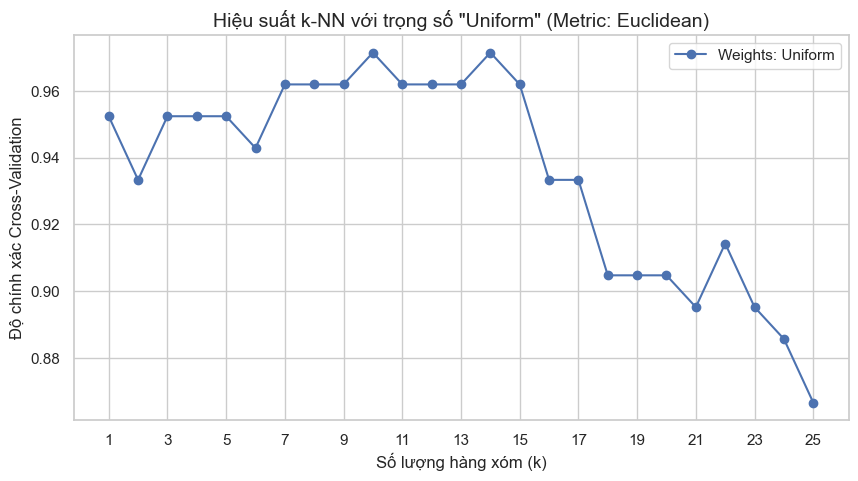

✅ Kết quả tốt nhất cho 'Uniform':
   - k tối ưu: 14
   - Khoảng cách (p): 2
   - Độ chính xác CV tốt nhất: 0.9714


In [14]:
# ==========================================
# 3. TRỌNG SỐ UNIFORM
# ==========================================
print("\n--- 3. Phân tích Trọng số Đồng nhất (Uniform) ---")
param_grid = {'n_neighbors': np.arange(1, 26), 'p': [1, 2]}
knn_uniform = KNeighborsClassifier(weights='uniform')
grid_uniform = GridSearchCV(knn_uniform, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_uniform.fit(X_train_scaled, y_train)
analyze_and_plot(grid_uniform, "Uniform")


--- 4. Phân tích Trọng số Distance ---


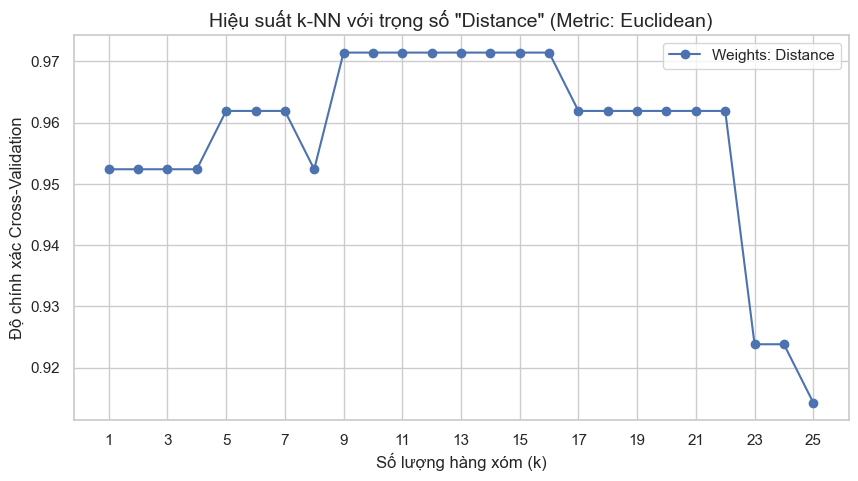

✅ Kết quả tốt nhất cho 'Distance':
   - k tối ưu: 5
   - Khoảng cách (p): 1
   - Độ chính xác CV tốt nhất: 0.9714


In [15]:
# ==========================================
# 4. TRỌNG SỐ DISTANCE
# ==========================================
print("\n--- 4. Phân tích Trọng số Distance ---")
knn_distance = KNeighborsClassifier(weights='distance')
grid_distance = GridSearchCV(knn_distance, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_distance.fit(X_train_scaled, y_train)
analyze_and_plot(grid_distance, "Distance")


5. SO SÁNH HIỆU SUẤT CUỐI CÙNG TRÊN TẬP TEST
  Phương pháp  k tối ưu  Metric (p)  Độ chính xác Test Set
0     Uniform        14           2               0.955556
1    Distance         5           1               0.933333


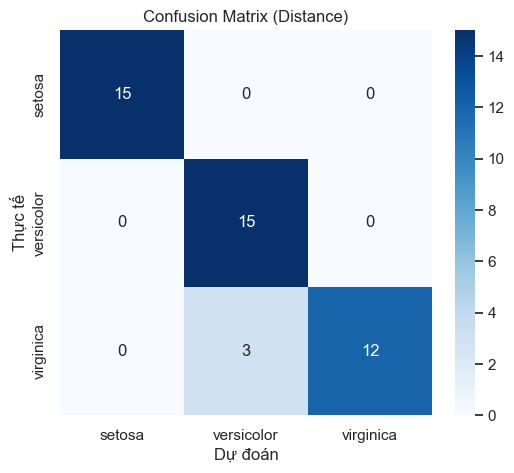


Báo cáo phân loại:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.83      1.00      0.91        15
   virginica       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



In [16]:
# ==========================================
# 5. ĐÁNH GIÁ TRÊN TEST SET
# ==========================================
print("\n" + "="*60)
print("5. SO SÁNH HIỆU SUẤT CUỐI CÙNG TRÊN TẬP TEST")
print("="*60)

best_model_uniform = grid_uniform.best_estimator_
best_model_distance = grid_distance.best_estimator_

y_pred_uni = best_model_uniform.predict(X_test_scaled)
y_pred_dist = best_model_distance.predict(X_test_scaled)

acc_uni = accuracy_score(y_test, y_pred_uni)
acc_dist = accuracy_score(y_test, y_pred_dist)

comparison_df = pd.DataFrame({
    'Phương pháp': ['Uniform', 'Distance'],
    'k tối ưu': [grid_uniform.best_params_['n_neighbors'], grid_distance.best_params_['n_neighbors']],
    'Metric (p)': [grid_uniform.best_params_['p'], grid_distance.best_params_['p']],
    'Độ chính xác Test Set': [acc_uni, acc_dist]
})

print(comparison_df)
 
cm = confusion_matrix(y_test, y_pred_dist)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.title('Confusion Matrix (Distance)')
plt.show()

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_dist, target_names=class_names))

In [7]:
%pip install matplotlib seaborn scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.
